In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import MySQLdb
import time

from sympy import *
from sympy.solvers import solve
from sympy.parsing.sympy_parser import parse_expr


In [2]:
j = 0
d = 31

time_a = pd.date_range('2016-10-01 00:00:00', periods=96*d, freq='15T')
time_b = pd.date_range('2016-10-01 00:14:59', periods=96*d, freq='15T')

conn = MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()

query_empty = """truncate table thesis.pv600batt3""" 
c.execute(query_empty)
print "thesis.pv600batt3 are Empty!!! \n"

query1 = "SELECT Timestamp,total_watt  FROM thesis.load WHERE  Timestamp >= '%s'   AND Timestamp <= '%s'; " % (time_a[0],time_b[(96*d)-1])
df1 = pd.read_sql(query1, conn)

query = "SELECT Timestamp,PV FROM thesis.PV WHERE Timestamp>='%s' AND Timestamp<='%s'; "%('2016-10-01 00:00:00','2016-10-31 23:59:59')
df = pd.read_sql(query, conn)
df['PV'] = ((df.PV/10)*2)

batt = float(2.9*1000)
minbatt = batt * 0.2
maxbatt = batt
levelbatt = []
levelbatt.append(float(batt))
pv_watt = []
batt_watt = []
grid_watt = []
effi = float(1.04)
pv_consumption = []
batt_consumption = []
grid_consumption = []

overpv = float(0)
sum_overpv = float(0)
charging_watt = float(0)

while ( j <= (96*d) -1):
    print j,"at time",time_b[j]
    if (df.PV[j] != 0):
        if (levelbatt[j] == maxbatt):
            batt_t = levelbatt[j] - minbatt
            watt = df1.total_watt[j] 
            if (df.PV[j] > watt):
                pv_consumption.append(float(watt))
                batt_consumption.append(float(0))
                grid_consumption.append(float(0))
                levelbatt.append(float(levelbatt[j]))
                overpv = df.PV[j] - watt
                sum_overpv += overpv
            else:
                lefted_pv = watt-df.PV[j]
                pv_consumption.append(float(df.PV[j]))
                if (batt_t > lefted_pv):
                    batt_consumption.append(float(lefted_pv))
                    grid_consumption.append(float(0))
                    levelbatt.append(float(levelbatt[j]-lefted_pv))
                else:
                    lefted_batt = lefted_pv - batt_t
                    batt_consumption.append(float(batt_t))
                    grid_consumption.append(float(lefted_batt))
                    levelbatt.append(float(levelbatt[j]-batt_t))                                          
        else:
            batt_t = levelbatt[j] - minbatt
            watt = df1.total_watt[j] 
            if (df.PV[j] > watt):
                pv_consumption.append(float(watt))
                batt_consumption.append(float(0))
                grid_consumption.append(float(0))
                charging_watt = df.PV[j] - watt
                missing_watt = (maxbatt - levelbatt[j])*effi
                if (charging_watt > missing_watt):
                    charging_watt = missing_watt /effi
                    overpv = df.PV[j] - watt - missing_watt
                else:
                    charging_watt = charging_watt /effi
                    overpv = 0
                levelbatt.append(float(levelbatt[j]+(charging_watt)))               
                sum_overpv += overpv  
            else:
                lefted_pv = watt-df.PV[j]
                pv_consumption.append(float(df.PV[j]))
                if (batt_t > lefted_pv):
                    batt_consumption.append(float(lefted_pv))
                    grid_consumption.append(float(0))
                    levelbatt.append(float(levelbatt[j]-lefted_pv))
                else:
                    lefted_batt = lefted_pv - batt_t
                    batt_consumption.append(float(batt_t))
                    grid_consumption.append(float(lefted_batt))
                    levelbatt.append(float(levelbatt[j]-batt_t))                        
    else :
        if (levelbatt[j] > minbatt):
            batt_t = levelbatt[j] - minbatt
            watt = df1.total_watt[j] 
            if (batt_t > watt):
                pv_consumption.append(float(0))
                batt_consumption.append(float(watt))
                grid_consumption.append(float(0))
                levelbatt.append(float(levelbatt[j]-watt))
            else:
                lefted_batt = watt - batt_t
                pv_consumption.append(float(0))
                batt_consumption.append(float(batt_t))
                grid_consumption.append(float(lefted_batt))
                levelbatt.append(float(levelbatt[j]-batt_t))          
        else:
            watt = df1.total_watt[j] 
            pv_consumption.append(float(0))
            batt_consumption.append(float(0))
            grid_consumption.append(float(watt))
            levelbatt.append(float(levelbatt[j]))
       
    c.execute("INSERT INTO  thesis.pv600batt3 (Timestamp,total_watt ,PV_genarator , levelbatt ,charging_watt,overpv, pv_consumption , batt_consumption,grid_consumption) VALUES ( %s,  %s,%s,%s, %s, %s, %s, %s, %s)",
              (time_b[j],df1.total_watt[j],df.PV[j],levelbatt[j],charging_watt,overpv,pv_consumption[j],batt_consumption[j],grid_consumption[j]))
    conn.commit()  
    charging_watt = float(0) 
    overpv = float(0)
    j +=1 
print "-------------YOUR PROGRAM IS DONE-----------------"

thesis.pv600batt3 are Empty!!! 

0 at time 2016-10-01 00:14:59
1 at time 2016-10-01 00:29:59
2 at time 2016-10-01 00:44:59
3 at time 2016-10-01 00:59:59
4 at time 2016-10-01 01:14:59
5 at time 2016-10-01 01:29:59
6 at time 2016-10-01 01:44:59
7 at time 2016-10-01 01:59:59
8 at time 2016-10-01 02:14:59
9 at time 2016-10-01 02:29:59
10 at time 2016-10-01 02:44:59
11 at time 2016-10-01 02:59:59
12 at time 2016-10-01 03:14:59
13 at time 2016-10-01 03:29:59
14 at time 2016-10-01 03:44:59
15 at time 2016-10-01 03:59:59
16 at time 2016-10-01 04:14:59
17 at time 2016-10-01 04:29:59
18 at time 2016-10-01 04:44:59
19 at time 2016-10-01 04:59:59
20 at time 2016-10-01 05:14:59
21 at time 2016-10-01 05:29:59
22 at time 2016-10-01 05:44:59
23 at time 2016-10-01 05:59:59
24 at time 2016-10-01 06:14:59
25 at time 2016-10-01 06:29:59
26 at time 2016-10-01 06:44:59
27 at time 2016-10-01 06:59:59
28 at time 2016-10-01 07:14:59
29 at time 2016-10-01 07:29:59
30 at time 2016-10-01 07:44:59
31 at time 2016-

In [3]:
print sum_overpv

0.0


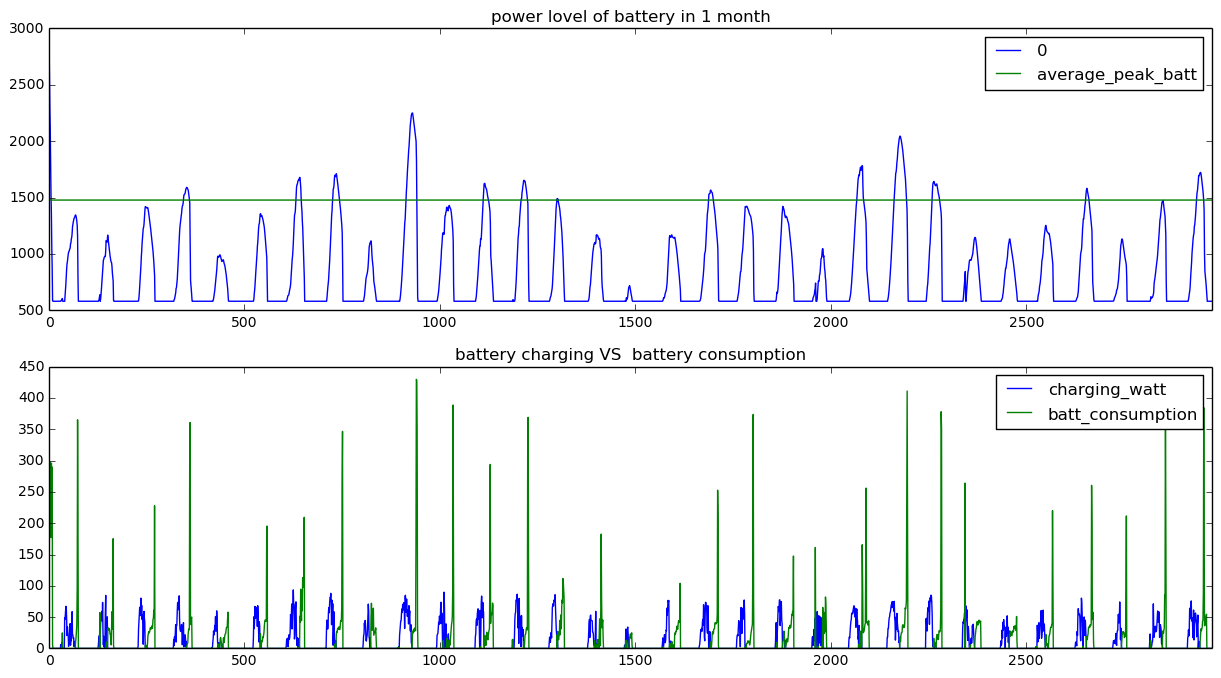

charging_watt  27.122170728


In [7]:
import pandas as pd
import MySQLdb
import numpy as np
import time
import datetime 
import random
import matplotlib.pyplot as plt
%matplotlib inline 

conn= MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()

query0 =  "SELECT Timestamp, levelbatt  FROM  thesis.pv600batt3  WHERE Timestamp >= '2016-10-01 00:14:59' AND  Timestamp <= '2016-10-31 23:59:59';"
df0 = pd.read_sql(query0, conn)

query1 =  "SELECT Timestamp, charging_watt,batt_consumption FROM  thesis.pv600batt3  WHERE Timestamp >= '2016-10-01 00:14:59' AND  Timestamp <= '2016-10-31 23:59:59';"
df1 = pd.read_sql(query1, conn)


a =range(1,len(df0),1)
for i in a:
    a[i-1] = 1477.582903
    
a = pd.DataFrame(a,columns = ["average_peak_batt"])
frames = [df0.levelbatt  , a ]
result = pd.concat(frames)

fig, (ax0,ax1) = plt.subplots(nrows=2,figsize=(5*3, 4*2))
ax0.set_title('power lovel of battery in 1 month ')
ax1.set_title('battery charging VS  battery consumption')
result.plot(ax=ax0 )
df1.plot(ax=ax1)
plt.show()
print "charging_watt ",df1.charging_watt.sum()/1000

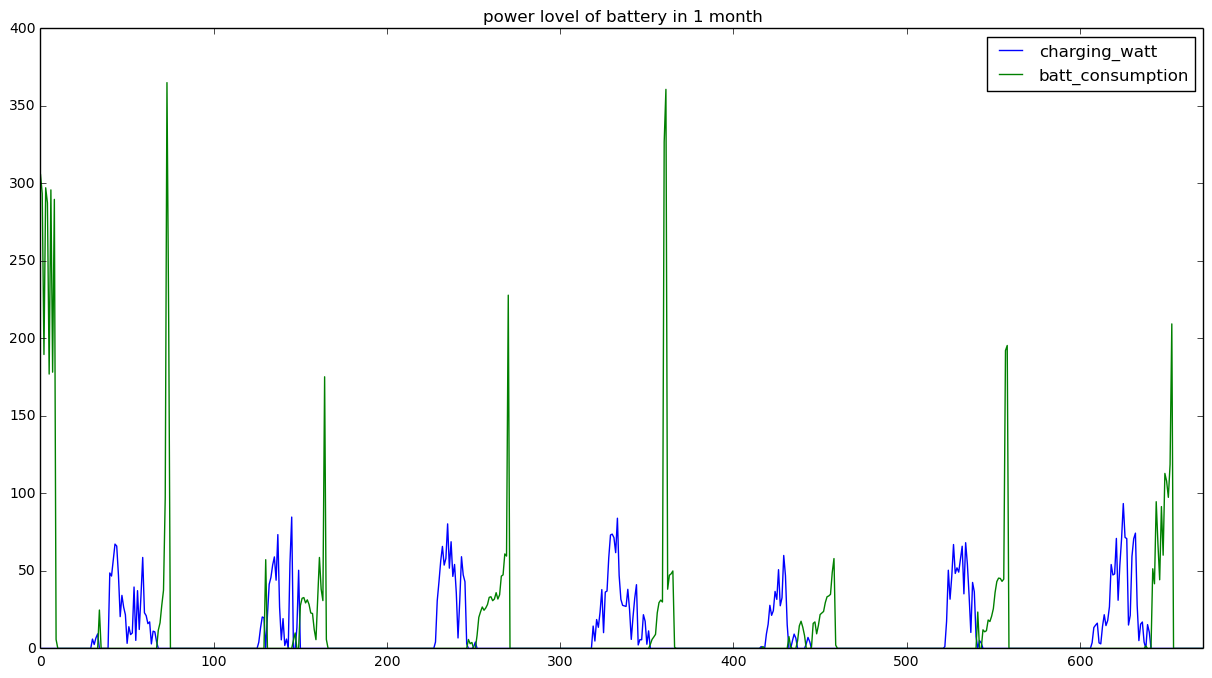

Total unit consumption || No-algorithm & PVBATT || equal to 383.111085 kW equal to 1595.63 bath
Total power consumption from PEA equal to 318.215388318 kW equal to 1305.8 bath
BATT  29.442169327
PV  35.4535267256
PV_genarator  63.6605821256


In [5]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
import matplotlib.pyplot as plt
import pandas as pd # v. 1.7
import numpy as np
import MySQLdb
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time
import datetime 
import random
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
import MySQLdb
import time

from sympy import *
from sympy.solvers import solve
from sympy.parsing.sympy_parser import parse_expr
%matplotlib inline  
# x = raw_input('What about Ft?')
# Ft = float(x)
Ft = -0.048
t1 = 3.2484      # rate_1
t2 = 4.2218      # rate_2
t3 = 4.4217      # rate_3
ser = 38.22      # service_charge
u = symbols('u')

def bill(allpow):    
    ## Fundamental parameter
    if allpow == 0:
        bath = 0
    elif 1 <= allpow <= 150:
        bath = allpow*t1
    elif  151 <= allpow <= 400:
        power = allpow-150
        bath_1 = 150*t1
        bath_2 = power*t2
        bath = bath_1+bath_2
    else:
        power = allpow-150
        bath_1 = 150*t1
        power = power-250
        bath_2 = 250*t2
        bath_3 = power*t3
        bath = bath_1+bath_2+bath_3   
    service_price = 38.22  #permonth (fixed)   
    ## FT -33.2 satang/unit
    FT_price = allpow*Ft
    ## VAT 7%
    VAT_price = ((service_price+bath)+FT_price)*0.07
    bill = bath+service_price+FT_price+VAT_price
    return round(bill,2)

conn= MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()

query1 =  "SELECT Timestamp, charging_watt,batt_consumption FROM  thesis.pv600batt3  WHERE Timestamp >= '2016-10-01 00:14:59' AND  Timestamp <= '2016-10-07 23:59:59';"
df1 = pd.read_sql(query1, conn)

fig, (ax) = plt.subplots(figsize=(5*3, 4*2))
ax.set_title('power lovel of battery in 1 month ')
df1.plot(ax=ax )
plt.show()

query0 = "SELECT Timestamp,total_watt,PV_genarator,pv_consumption,batt_consumption,grid_consumption FROM thesis.pv600batt3  WHERE  Timestamp >= '2016-10-01 00:14:59' AND  Timestamp <= '2016-10-31 23:59:59';"
df = pd.read_sql(query0, conn)
print "Total unit consumption || No-algorithm & PVBATT || equal to",df.total_watt.sum()/1000,"kW equal to", bill(df.total_watt.sum()/1000),"bath"
print "Total power consumption from PEA equal to",df.grid_consumption.sum()/1000,"kW equal to", bill(df.grid_consumption.sum()/1000),"bath"
print "BATT ", df.batt_consumption.sum()/1000
print "PV ",df.pv_consumption.sum()/1000
print "PV_genarator ",df.PV_genarator.sum()/1000

DONE


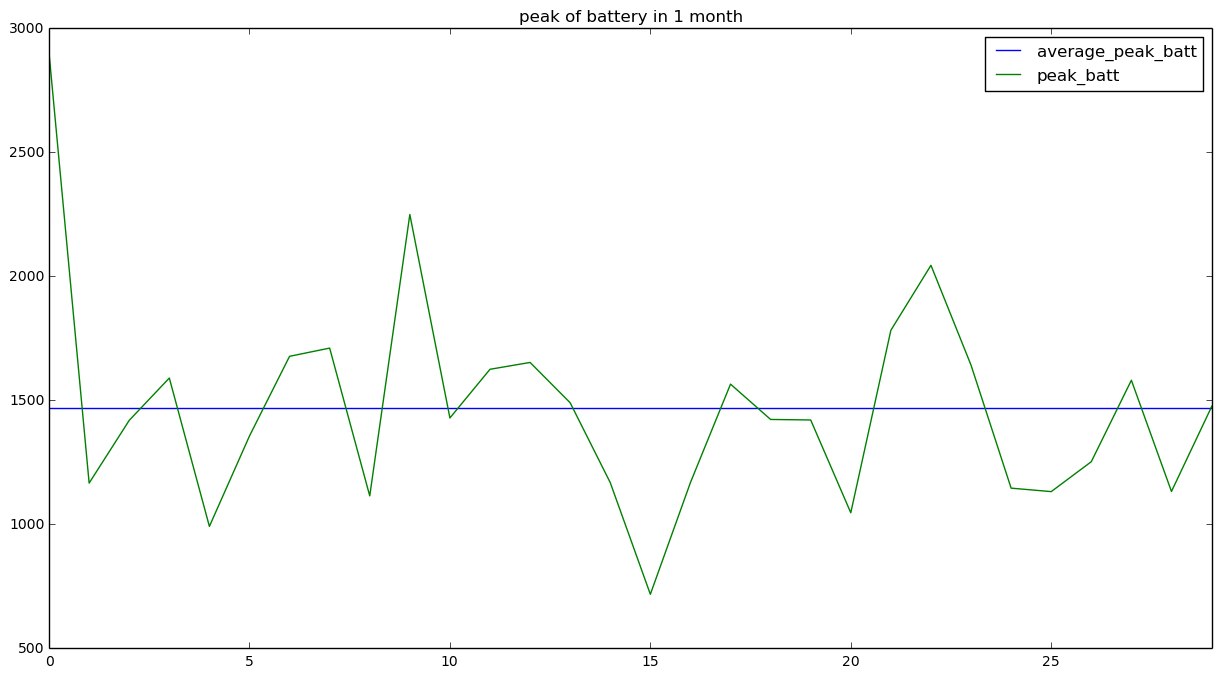

peak_batt    1477.582903
dtype: float64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import MySQLdb
import time

from sympy import *
from sympy.solvers import solve
from sympy.parsing.sympy_parser import parse_expr
import numpy as np
%matplotlib inline  
i = 0
d = 31
time_a = pd.date_range('2016-10-01', periods=1*d, freq='D')
time_b = pd.date_range('2016-10-01 23:59:59', periods= 1*d, freq='D')

conn= MySQLdb.connect("localhost","conn","hems")
c = conn.cursor()
aver = []

while(i <= 30):  
    query1 =  "SELECT Timestamp, levelbatt FROM  thesis.pv600batt3  WHERE Timestamp >= '%s' AND TimeStamp <= '%s'; "% (time_a[i],time_b[i])
    df1 = pd.read_sql(query1, conn)
    aver.append(max(df1.levelbatt))
    i += 1
#     print "END", i, "DAY"
print "DONE"


a =range(1,len(aver),1)
for i in a:
    a[i-1] = 1469.683129

maxs = pd.DataFrame(aver,columns = ["peak_batt"])
mean = np.mean(maxs)
a = pd.DataFrame(a,columns = ["average_peak_batt"])
frames = [maxs , a ]
result = pd.concat(frames)
fig, (ax) = plt.subplots(figsize=(5*3, 4*2))
ax.set_title('peak of battery in 1 month ')
result.plot(ax=ax )
plt.show()
print mean